In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings

warnings.filterwarnings('ignore')

# 1. Load Data Robustly
file_path = None
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if 'cleaned_data' in filename:
            file_path = os.path.join(dirname, filename)
            break
            
if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
else:
    df = pd.read_excel(file_path)

# 2. Preprocess Labels
if 'Lable' in df.columns:
    df.rename(columns={'Lable': 'Label'}, inplace=True)

label_map = {'Not Relevant': 0, 'Partially Relevant': 1, 'Highly Relevant': 2}
df['label'] = df['Label'].map(label_map)
class_names = ['Not Relevant', 'Partially Relevant', 'Highly Relevant']

# 3. Create Features
# Approach 1: Combined
df['text_combined'] = (
    "Genre: " + df['Symptoms Genre_cleaned'].astype(str) + 
    " Prompt: " + df['Used Prompt_cleaned'].astype(str) + 
    " Response: " + df['Response_cleaned'].astype(str)
)

# Approach 2: Response Only
df['text_response'] = "Response: " + df['Response_cleaned'].astype(str)

# 4. Split Data (Using same seed=42 for fair comparison)
# Note: SVM/RF don't need a validation set during training, so we merge Train+Val 
# to give them more data, or we can just use the same Train split. 
# Let's use Train (80%) and Test (10%) to be consistent with the DL models.
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Data Ready. Train: {len(train_df)}, Test: {len(test_df)}")

Data Ready. Train: 12307, Test: 1539


In [2]:
def robust_tokenizer(text):
    """Custom tokenizer to handle Bengali characters correctly"""
    return re.findall(r'[\w\u0980-\u09FF]+', str(text).lower())

def plot_multiclass_roc(y_test, y_probs, n_classes, title):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green']
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, 
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def run_ml_experiment(experiment_name, model, X_train, y_train, X_test, y_test):
    print(f"\n{'='*40}")
    print(f"🚀 Running: {experiment_name}")
    print(f"{'='*40}")
    
    # 1. Train
    model.fit(X_train, y_train)
    
    # 2. Predict
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    
    # 3. Metrics
    print(f"\n--- Classification Report: {experiment_name} ---")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    
    # 4. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{experiment_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # 5. ROC Curve
    plot_multiclass_roc(y_test, y_probs, 3, experiment_name)

In [3]:
print("Vectorizing Text (TF-IDF)...")

# --- Approach 1: Combined ---
tfidf_1 = TfidfVectorizer(tokenizer=robust_tokenizer, max_features=15000)
X_train_1 = tfidf_1.fit_transform(train_df['text_combined'])
X_test_1 = tfidf_1.transform(test_df['text_combined'])

# --- Approach 2: Response Only ---
tfidf_2 = TfidfVectorizer(tokenizer=robust_tokenizer, max_features=15000)
X_train_2 = tfidf_2.fit_transform(train_df['text_response'])
X_test_2 = tfidf_2.transform(test_df['text_response'])

print("Vectorization Complete.")
print(f"Approach 1 Features: {X_train_1.shape}")
print(f"Approach 2 Features: {X_train_2.shape}")

Vectorizing Text (TF-IDF)...
Vectorization Complete.
Approach 1 Features: (12307, 9904)
Approach 2 Features: (12307, 9823)



🚀 Running: RandomForest_Appr1_Combined

--- Classification Report: RandomForest_Appr1_Combined ---
                    precision    recall  f1-score   support

      Not Relevant     0.8304    0.8287    0.8296       508
Partially Relevant     0.7360    0.7208    0.7283       530
   Highly Relevant     0.8031    0.8224    0.8126       501

          accuracy                         0.7895      1539
         macro avg     0.7898    0.7906    0.7902      1539
      weighted avg     0.7890    0.7895    0.7892      1539



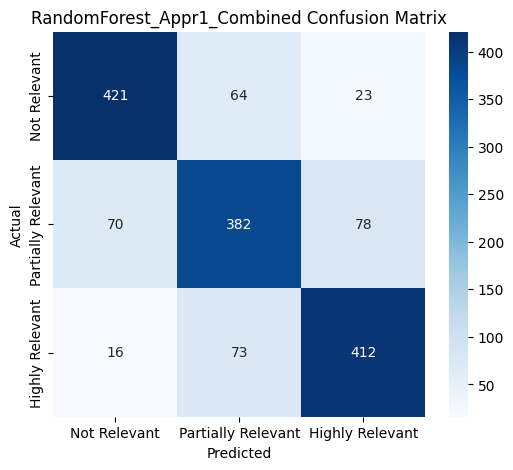

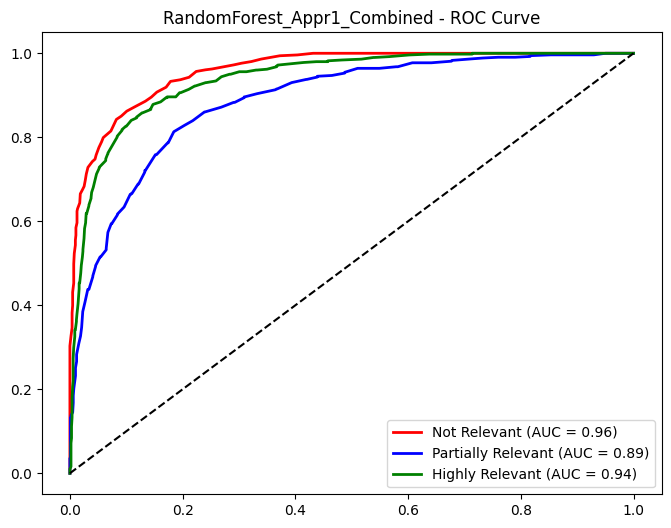


🚀 Running: RandomForest_Appr2_Response

--- Classification Report: RandomForest_Appr2_Response ---
                    precision    recall  f1-score   support

      Not Relevant     0.8180    0.7874    0.8024       508
Partially Relevant     0.7196    0.6925    0.7058       530
   Highly Relevant     0.7537    0.8124    0.7819       501

          accuracy                         0.7628      1539
         macro avg     0.7638    0.7641    0.7634      1539
      weighted avg     0.7632    0.7628    0.7625      1539



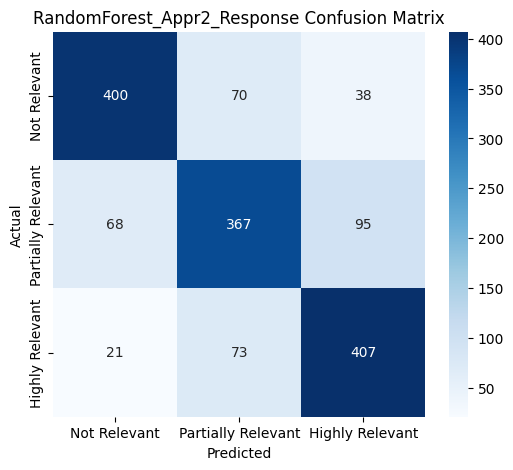

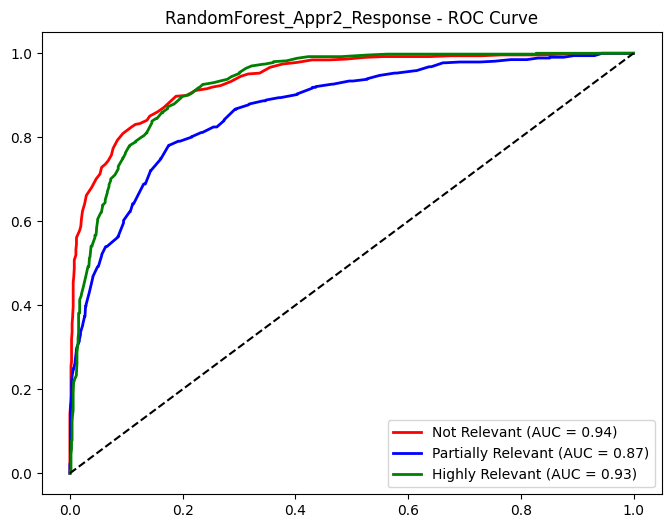

In [4]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# 1. RF on Approach 1 (Combined)
run_ml_experiment("RandomForest_Appr1_Combined", rf_model, 
                  X_train_1, train_df['label'], 
                  X_test_1, test_df['label'])

# 2. RF on Approach 2 (Response Only)
run_ml_experiment("RandomForest_Appr2_Response", rf_model, 
                  X_train_2, train_df['label'], 
                  X_test_2, test_df['label'])


🚀 Running: SVM_Appr1_Combined

--- Classification Report: SVM_Appr1_Combined ---
                    precision    recall  f1-score   support

      Not Relevant     0.8176    0.8209    0.8193       508
Partially Relevant     0.6958    0.6906    0.6932       530
   Highly Relevant     0.7753    0.7784    0.7769       501

          accuracy                         0.7622      1539
         macro avg     0.7629    0.7633    0.7631      1539
      weighted avg     0.7619    0.7622    0.7620      1539



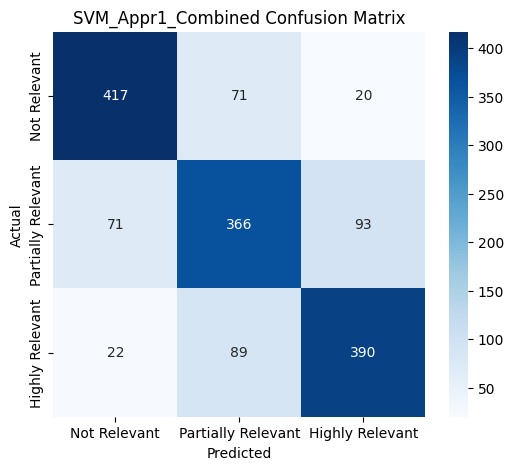

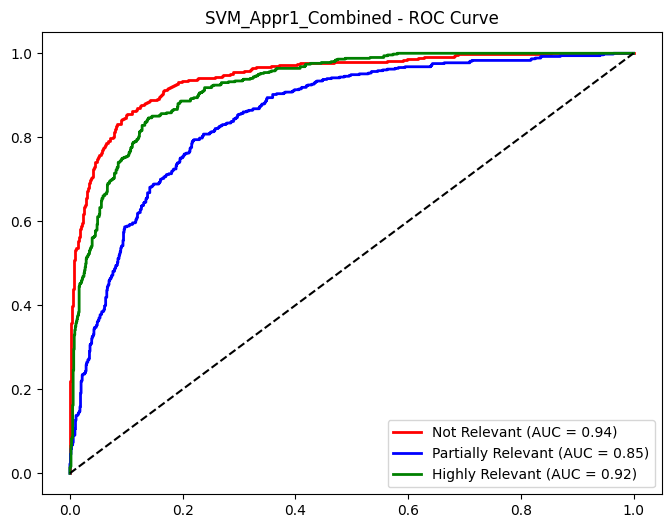


🚀 Running: SVM_Appr2_Response

--- Classification Report: SVM_Appr2_Response ---
                    precision    recall  f1-score   support

      Not Relevant     0.8165    0.7795    0.7976       508
Partially Relevant     0.6920    0.7038    0.6978       530
   Highly Relevant     0.7553    0.7764    0.7657       501

          accuracy                         0.7524      1539
         macro avg     0.7546    0.7532    0.7537      1539
      weighted avg     0.7537    0.7524    0.7529      1539



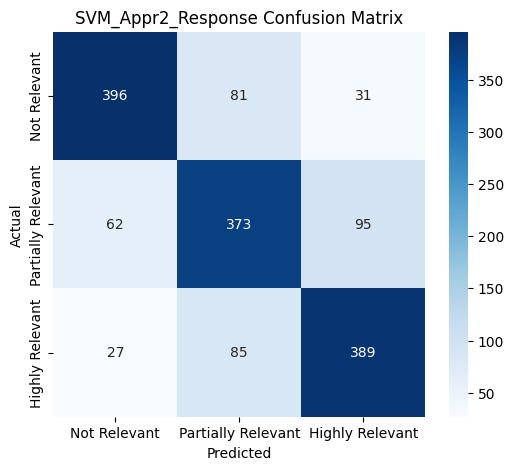

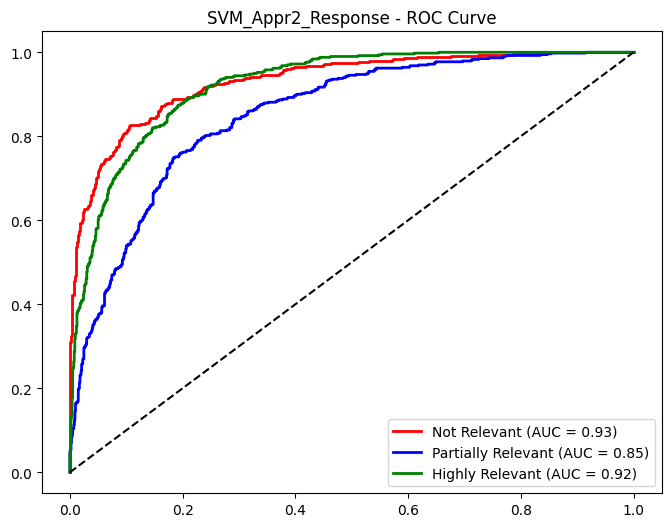

In [5]:
# Initialize SVM (probability=True is needed for ROC curves)
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42, class_weight='balanced')

# 1. SVM on Approach 1 (Combined)
run_ml_experiment("SVM_Appr1_Combined", svm_model, 
                  X_train_1, train_df['label'], 
                  X_test_1, test_df['label'])

# 2. SVM on Approach 2 (Response Only)
run_ml_experiment("SVM_Appr2_Response", svm_model, 
                  X_train_2, train_df['label'], 
                  X_test_2, test_df['label'])